In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from PIL import Image

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

NUM_EPOCHS = 10
BATCH_SIZE = 16
NUM_MASK_CHANNELS = 8

LEARNING_RATE = 1e-4

DATA_DIR = "/content/drive/MyDrive/yamaha_v0"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*/rgb.jpg")))
train_masks = sorted(glob(os.path.join(DATA_DIR, "train/*/labels.png")))
val_images = sorted(glob(os.path.join(DATA_DIR, "valid/*/rgb.jpg")))
val_masks = sorted(glob(os.path.join(DATA_DIR, "valid/*/labels.png")))

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img


IMG_HEIGHT = 512
IMG_WIDTH = 512
NUM_CLASSES = 9




def load_and_preprocess_image(image_path, mask_path):
    def load_image(image_path, mask_path):
        image = load_img(image_path.numpy().decode("utf-8"), target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = img_to_array(image) / 255.0

        # 마스크 로드 및 one-hot 인코딩
        mask = load_img(mask_path.numpy().decode("utf-8"), target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        mask = img_to_array(mask).squeeze()  # 채널 차원 제거
        mask = np.round(mask * (NUM_CLASSES - 1) / 255.0)  # 마스크 스케일 조정
        mask = tf.one_hot(tf.cast(mask, tf.int32), NUM_CLASSES)  # One-hot 인코딩
        return image, mask

    [image, mask] = tf.py_function(load_image, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES])
    return image, mask

def create_dataset(image_paths, mask_paths, batch_size):
    image_paths = tf.constant(image_paths)
    mask_paths = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
BATCH_SIZE = 16
train_dataset = create_dataset(train_images, train_masks, BATCH_SIZE)
val_dataset = create_dataset(val_images, val_masks, BATCH_SIZE)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    return img_array


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, multiply, add, GlobalAveragePooling2D, Dense, Reshape, Conv2DTranspose, BatchNormalization, SeparableConv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation, Multiply, Add, GlobalAveragePooling2D, Dense, Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
from tensorflow.keras.applications import EfficientNetB0
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature



from tensorflow.keras.layers import SeparableConv2D

def ResidualConvBlock(input_tensor, num_filters, kernel_size=3):
    x = SeparableConv2D(num_filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Residual Connection
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def SEBlock(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([input_tensor, se])
    return x

def DenseBlock(input_tensor, num_layers, growth_rate, dropout_rate=0.5):
    for i in range(num_layers):
        x = BatchNormalization()(input_tensor)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, (3, 3), padding='same')(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
        input_tensor = concatenate([input_tensor, x])
    return input_tensor

def AtrousSpatialPyramidPooling(input_tensor):

    filters = input_tensor.shape[-1]
    rate1 = Conv2D(filters, (1, 1), padding='same', activation='relu', dilation_rate=1)(input_tensor)
    rate2 = Conv2D(filters, (3, 3), padding='same', activation='relu', dilation_rate=6)(input_tensor)
    rate3 = Conv2D(filters, (3, 3), padding='same', activation='relu', dilation_rate=12)(input_tensor)
    rate4 = Conv2D(filters, (3, 3), padding='same', activation='relu', dilation_rate=18)(input_tensor)

    x = add([rate1, rate2, rate3, rate4])
    return x

from tensorflow.keras.layers import UpSampling2D, Concatenate

def decoder_block(input_tensor, skip_features, num_filters):
    input_attention = cbam_block(input_tensor)

    x = UpSampling2D((2, 2), interpolation='bilinear')(input_attention)

    # 스킵 커넥션에 attention 적용
    skip_attention = cbam_block(skip_features)
    x = Concatenate()([x, skip_attention])

    x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # 최종 출력에 다시 attention 적용
    x = cbam_block(x)

    return x


def build_enhanced_attention_unet(input_shape=(512, 512, 3), num_classes=8):
    inputs = Input(input_shape)

    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    down_stack = Model(inputs=base_model.input, outputs=layers)

    skips = down_stack(inputs)
    x = skips[-1]

    num_filters = [256, 128, 64, 32, 16]
    for i, num_filter in enumerate(num_filters):
        if i < len(skips) - 1:
            x = decoder_block(x, skips[-(i + 2)], num_filter)

    x = DenseBlock(x, num_layers=4, growth_rate=32)
    x = AtrousSpatialPyramidPooling(x)

    x = UpSampling2D(size=(2, 2))(x)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model




model = build_enhanced_attention_unet(input_shape=(512, 512, 3), num_classes=9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 256, 256, 96),       1841984   ['input_1[0][0]']             
                              (None, 128, 128, 144),                                              
                              (None, 64, 64, 192),                                                
                              (None, 32, 32, 576),                                                
                              (None, 16, 16, 320)]                                                
                             

In [ ]:
!pip install pydot graphviz


Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 1.2638 - accuracy: 0.5291

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 258s 2s/step - loss: 1.2638 - accuracy: 0.5291 - val_loss: 1.6542 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 33s 559ms/step - loss: 0.9735 - accuracy: 0.6130 - val_loss: 1.4257 - val_accuracy: 0.4044 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 32s 548ms/step - loss: 0.9603 - accuracy: 0.6231 - val_loss: 1.5738 - val_accuracy: 0.4034 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 32s 545ms/step - loss: 0.9305 - accuracy: 0.6332 - val_loss: 1.4482 - val_accuracy: 0.4604 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 32s 547ms/step - loss: 0.8609 - accuracy: 0.6514 - val_loss: 1.9956 - val_accuracy: 0.4353 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 32s 546ms/step - loss: 0.8272 - accuracy: 0.6543 - val_loss: 1.8390 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 33s 556ms/step - loss: 0.

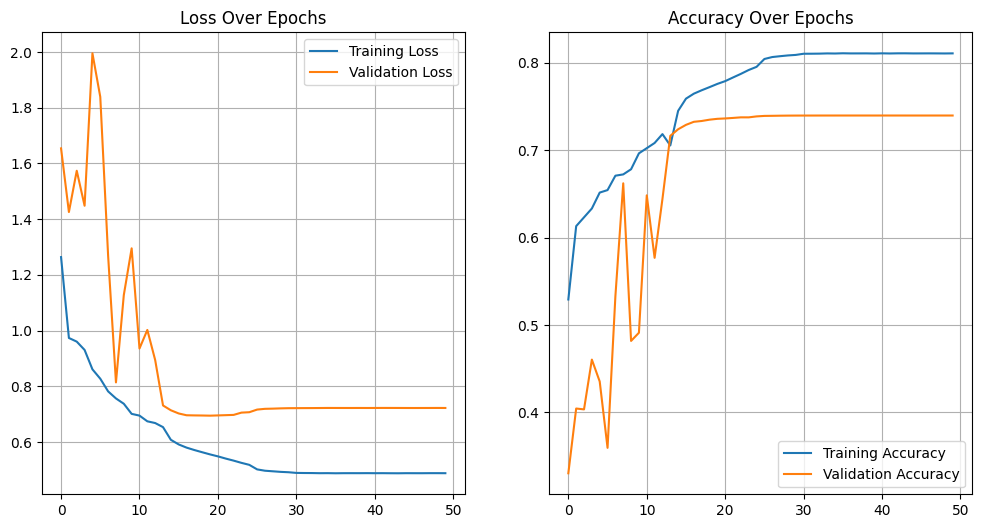

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint(
    'attention_unet_best.h5',
    monitor='val_loss',
    save_best_only=True
)


early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)


reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb, reduce_lr_cb, tensorboard_cb]
)


import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_history(history)

1/1 [==============================] - 3s 3s/step


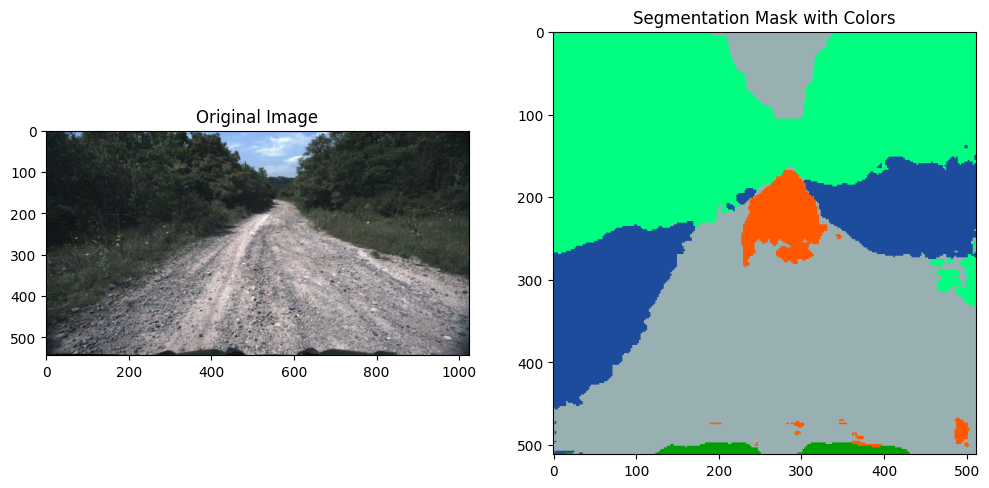

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


LABEL_TO_COLOR = OrderedDict({
    "background": [255, 255, 255],  # 흰색
    "high_vegetation": [0, 80, 40],  # 짙은 녹색
    "traversable_grass": [0, 255, 128],  # 밝은 녹색
    "smooth_trail": [153, 176, 178],  # 회색 경로
    "obstacle": [0, 0, 255],  # 빨간색 장애물
    "sky": [255, 88, 1],  # 파란색 하늘
    "rough_trial": [30, 76, 156],  # 갈색 거친 길
    "puddle": [128, 0, 255],
    "non_traversable_low_vegetation": [0, 160, 0]
})


def visualize_prediction_with_colors(original_image, prediction):
    # 마스크에서 각 클래스에 대한 인덱스를 추출
    prediction = np.argmax(prediction, axis=-1)
    prediction = prediction.squeeze()

    # 출력 이미지를 생성 (RGB)
    output_image = np.zeros((*prediction.shape, 3), dtype=np.uint8)

    # 각 클래스에 대한 색깔로 이미지 채우기
    for class_index, (class_name, color) in enumerate(LABEL_TO_COLOR.items()):
        output_image[prediction == class_index] = color

    # 원본 이미지와 색깔로 칠한 마스크 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(output_image)
    ax[1].set_title('Segmentation Mask with Colors')
    plt.show()

# 이미지 로드 및 전처리 함수
def preprocess_image(image_path, target_size=(512, 512)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # 모델 예측을 위해 배치 차원 추가
    image = image / 255.0  # 정규화
    return image

# 예측된 마스크를 시각화하는 함수
def visualize_prediction(original_image, prediction, num_classes=8):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)  # 'squeeze()' 제거
    ax[0].set_title('Original Image')

    # 클래스별 확률을 가장 높은 확률을 가진 클래스로 변환
    prediction = np.argmax(prediction, axis=-1)
    prediction = prediction.squeeze()

    ax[1].imshow(prediction, cmap='jet', interpolation='nearest')
    ax[1].set_title('Segmentation Mask')
    plt.show()



model_path = '/content/attention_unet_best.h5'
model = load_model(model_path)

# 이미지 로드 및 전처리
image_path = '/content/drive/MyDrive/yamaha_v0/valid/iid000842/rgb.jpg'
preprocessed_image = preprocess_image(image_path)

# 모델 예측
predictions = model.predict(preprocessed_image)

# 예측 결과 시각화
original_image = load_img(image_path)

visualize_prediction_with_colors(original_image, predictions)



Center Overlap: 309, Left Overlap: 348, Right Overlap: 248


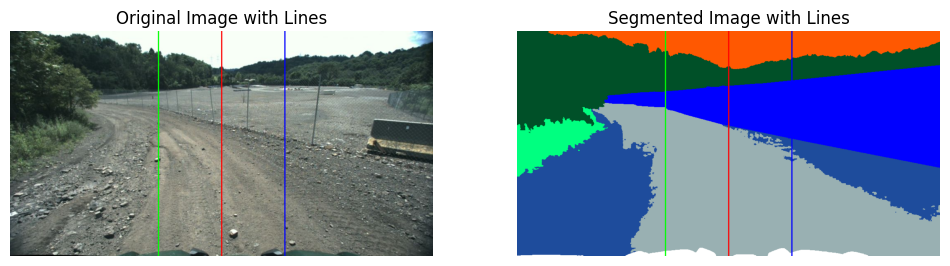

Direction: Straight


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


LABEL_TO_COLOR = OrderedDict({
    "background": [255, 255, 255],  # 흰색
    "high_vegetation": [0, 80, 40],  # 짙은 녹색
    "traversable_grass": [0, 255, 128],  # 밝은 녹색
    "smooth_trail": [153, 176, 178],  # 회색 경로
    "obstacle": [0, 0, 255],  # 빨간색 장애물
    "sky": [255, 88, 1],  # 파란색 하늘
    "rough_trial": [30, 76, 156],  # 갈색 거친 길
    "puddle": [128, 0, 255],
    "non_traversable_low_vegetation": [0, 160, 0]
})


# 세그먼테이션된 이미지를 레이블 이미지로 변환하는 함수
def convert_segmented_to_label(segmented_image, label_to_color):
    label_image = np.zeros(segmented_image.shape[:2], dtype=np.uint8)
    for label, color in label_to_color.items():
        mask = np.all(segmented_image == np.array(color), axis=-1)
        label_image[mask] = list(label_to_color.keys()).index(label)
    return label_image


# 방향을 결정하는 함수
def calculate_direction(label_image, label_to_color):
    height, width = label_image.shape
    center_line_x = width // 2
    left_line_x = center_line_x - int(width * 0.15)
    right_line_x = center_line_x + int(width * 0.15)

    traversable_labels = [list(label_to_color.keys()).index(key) for key in ['smooth_trail', 'traversable_grass']]

    # 중앙선에서 통행 가능 영역의 겹침 계산
    center_overlap = np.isin(label_image[:, center_line_x], traversable_labels).sum()

    # 이미지 높이의 절대적 비율로 중앙선에서의 겹침이 감소했는지 확인
    if center_overlap < height * 0.5:  # 예를 들어, 높이의 80% 이하로 줄어듦
        left_overlap = np.isin(label_image[:, left_line_x], traversable_labels).sum()
        right_overlap = np.isin(label_image[:, right_line_x], traversable_labels).sum()

        # 어느 방향으로 길이 더 열려 있는지 결정
        if left_overlap > right_overlap:
            return "Turn Left"
        else:
            return "Turn Right"
    return "Straight"


def visualize_images_with_lines(original_image_path, segmented_image_path, label_to_color):
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    segmented_image = cv2.imread(segmented_image_path)
    label_image = convert_segmented_to_label(segmented_image, label_to_color)

    # 중앙선과 양쪽 라인의 좌표 계산
    height, width = original_image.shape[:2]
    center_line_x = width // 2
    left_line_x = center_line_x - int(width * 0.15)
    right_line_x = center_line_x + int(width * 0.15)

    # 원본 이미지와 세그먼테이션된 이미지에 선 그리기
    for image in [original_image, segmented_image]:
        cv2.line(image, (center_line_x, 0), (center_line_x, height), (255, 0, 0), 2)  # 중앙선
        cv2.line(image, (left_line_x, 0), (left_line_x, height), (0, 255, 0), 2)  # 왼쪽 라인
        cv2.line(image, (right_line_x, 0), (right_line_x, height), (0, 0, 255), 2)  # 오른쪽 라인

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image with Lines')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Segmented Image with Lines')
    plt.axis('off')

    plt.show()

    # 방향 결정 및 출력
    direction = calculate_direction(label_image, LABEL_TO_COLOR)
    print("Direction:", direction)


original_image_path = "/content/drive/MyDrive/yamaha_v0/train/iid000127/rgb.jpg"
segmented_image_path = "/content/drive/MyDrive/yamaha_v0/train/iid000127/labels.png"



# label_image 생성
segmented_image = cv2.imread(segmented_image_path)  # 세그먼테이션된 이미지 로드
label_image = convert_segmented_to_label(segmented_image, LABEL_TO_COLOR)  # 레이블 이미지 변환


# traversable_labels 생성
traversable_labels = [list(LABEL_TO_COLOR.keys()).index(key) for key in ['smooth_trail', 'traversable_grass']]

height, width = label_image.shape
center_line_x = width // 2
left_line_x = center_line_x - int(width * 0.15)
right_line_x = center_line_x + int(width * 0.15)

# 선별적 영역의 겹침 계산
center_overlap = np.isin(label_image[:, center_line_x], traversable_labels).sum()
left_overlap = np.isin(label_image[:, left_line_x], traversable_labels).sum()
right_overlap = np.isin(label_image[:, right_line_x], traversable_labels).sum()

print(f"Center Overlap: {center_overlap}, Left Overlap: {left_overlap}, Right Overlap: {right_overlap}")

visualize_images_with_lines(original_image_path, segmented_image_path, LABEL_TO_COLOR)



1/1 [==============================] - 3s 3s/step


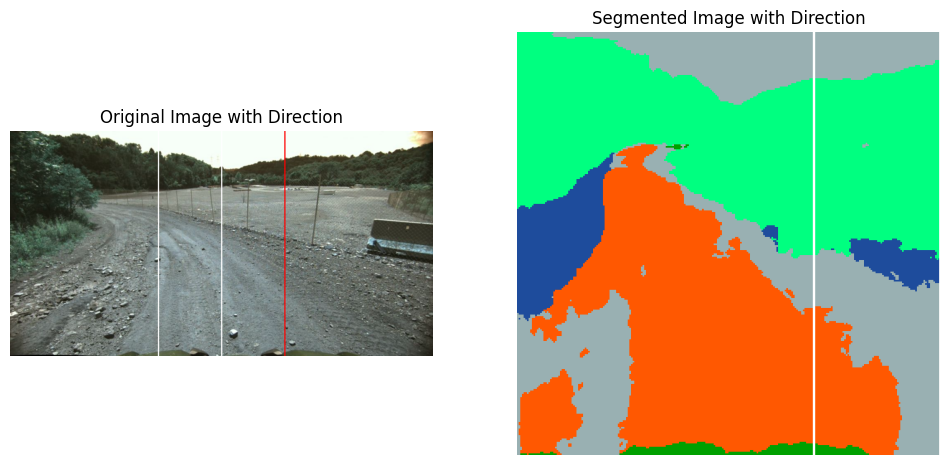

Direction: Turn Right
Center Overlap: 258
Left Overlap: 178
Right Overlap: 320


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from collections import OrderedDict
import cv2  # OpenCV 모듈 import

# 이미지 로드 및 전처리 함수
def preprocess_image(image_path, target_size=(512, 512)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # 모델 예측을 위해 배치 차원 추가
    image = image / 255.0  # 정규화
    return image

# 예측 결과를 색상으로 변환하는 함수
def visualize_prediction_with_colors(original_image, prediction, label_to_color):
    # 마스크에서 각 클래스에 대한 인덱스를 추출하여 색상으로 변환
    prediction = np.argmax(prediction, axis=-1).squeeze()
    output_image = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    for class_index, (class_name, color) in enumerate(label_to_color.items()):
        output_image[prediction == class_index] = color
    return output_image

# 세그먼테이션된 이미지를 레이블 이미지로 변환하는 함수
def convert_segmented_to_label(segmented_image, label_to_color):
    label_image = np.zeros(segmented_image.shape[:2], dtype=np.uint8)
    for label, color in label_to_color.items():
        mask = np.all(segmented_image == np.array(color), axis=-1)
        label_image[mask] = list(label_to_color.keys()).index(label)
    return label_image

# 방향을 결정하는 함수
def calculate_direction(label_image, label_to_color, traversable_labels):
    height, width = label_image.shape
    center_line_x = width // 2
    center_overlap = np.isin(label_image[:, center_line_x], traversable_labels).sum()
    left_line_x = center_line_x - int(width * 0.15)
    right_line_x = center_line_x + int(width * 0.15)
    left_overlap = np.isin(label_image[:, left_line_x], traversable_labels).sum()
    right_overlap = np.isin(label_image[:, right_line_x], traversable_labels).sum()
    if center_overlap < height * 0.6:
        if left_overlap > right_overlap:
            direction = "Turn Left"
        else:
            direction = "Turn Right"
    else:
        direction = "Straight"
    return direction, center_overlap, left_overlap, right_overlap

# 이미지에 방향 시각화

def visualize_direction_on_images(original_image, segmented_image, direction, label_to_color, center_overlap, left_overlap, right_overlap):

    height, width, _ = original_image.shape
    center_line_x = width // 2
    left_line_x = center_line_x - int(width * 0.15)
    right_line_x = center_line_x + int(width * 0.15)


    line_points = [(center_line_x, 0, center_line_x, height),
                   (left_line_x, 0, left_line_x, height),
                   (right_line_x, 0, right_line_x, height)]


    color_center = (255, 0, 0)  # Blue
    color_side = (0, 255, 0) if direction == "Turn Left" else (0, 0, 255)  # Green for Left, Red for Right
    color_straight = (255, 255, 255)  # White for Straight


    for image in [original_image, segmented_image]:
        cv2.line(image, line_points[0][:2], line_points[0][2:], color_center if direction == "Straight" else color_straight, 2)
        cv2.line(image, line_points[1][:2], line_points[1][2:], color_side if direction == "Turn Left" else color_straight, 2)
        cv2.line(image, line_points[2][:2], line_points[2][2:], color_side if direction == "Turn Right" else color_straight, 2)

    # 시각화
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # cv2 이미지를 RGB로 변환하여 출력
    plt.title('Original Image with Direction')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image.astype(np.uint8))
    plt.title('Segmented Image with Direction')
    plt.axis('off')

    plt.show()

    print(f"Direction: {direction}")
    print(f"Center Overlap: {center_overlap}")
    print(f"Left Overlap: {left_overlap}")
    print(f"Right Overlap: {right_overlap}")



# 레이블과 색상 매핑
LABEL_TO_COLOR = OrderedDict({
    "background": [255, 255, 255],  # 흰색
    "high_vegetation": [0, 80, 40],  # 짙은 녹색
    "traversable_grass": [0, 255, 128],  # 밝은 녹색
    "smooth_trail": [153, 176, 178],  # 회색 경로
    "obstacle": [0, 0, 255],  # 빨간색 장애물
    "sky": [255, 88, 1],  # 파란색 하늘
    "rough_trial": [30, 76, 156],  # 갈색 거친 길
    "puddle": [128, 0, 255],
    "non_traversable_low_vegetation": [0, 160, 0]
})


# 모델 로드 및 예측
model_path = '/content/attention_unet_best.h5'
model = load_model(model_path)
image_path = '/content/drive/MyDrive/yamaha_v0/train/iid000127/rgb.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = model.predict(preprocessed_image)

# 원본 이미지 로드
original_image = load_img(image_path)
original_image = img_to_array(original_image) / 255.0

# 예측 결과로부터 세그먼테이션된 이미지 생성
segmented_image = visualize_prediction_with_colors(original_image, predictions, LABEL_TO_COLOR)

# 세그먼테이션된 이미지를 레이블 이미지로 변환
label_image = convert_segmented_to_label(segmented_image, LABEL_TO_COLOR)

# 통행 가능한 레이블 인덱스 결정
traversable_labels = [list(LABEL_TO_COLOR.keys()).index(key) for key in ['smooth_trail', 'traversable_grass']]

# 방향 결정
direction, center_overlap, left_overlap, right_overlap = calculate_direction(label_image, LABEL_TO_COLOR, traversable_labels)


# 이미지에 방향 시각화
visualize_direction_on_images(original_image, segmented_image, direction, LABEL_TO_COLOR, center_overlap, left_overlap, right_overlap)
